In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow.keras as keras
import tensorflow as tf
import missingno as msno

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
raw_data = pd.read_csv('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Playground_Series_052021/train.csv')
test = pd.read_csv('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Playground_Series_052021/test.csv')

extras = raw_data[['id', 'target']]
data = raw_data.drop(['id', 'target'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feature_0   100000 non-null  int64
 1   feature_1   100000 non-null  int64
 2   feature_2   100000 non-null  int64
 3   feature_3   100000 non-null  int64
 4   feature_4   100000 non-null  int64
 5   feature_5   100000 non-null  int64
 6   feature_6   100000 non-null  int64
 7   feature_7   100000 non-null  int64
 8   feature_8   100000 non-null  int64
 9   feature_9   100000 non-null  int64
 10  feature_10  100000 non-null  int64
 11  feature_11  100000 non-null  int64
 12  feature_12  100000 non-null  int64
 13  feature_13  100000 non-null  int64
 14  feature_14  100000 non-null  int64
 15  feature_15  100000 non-null  int64
 16  feature_16  100000 non-null  int64
 17  feature_17  100000 non-null  int64
 18  feature_18  100000 non-null  int64
 19  feature_19  100000 non-null  int64
 20  featu

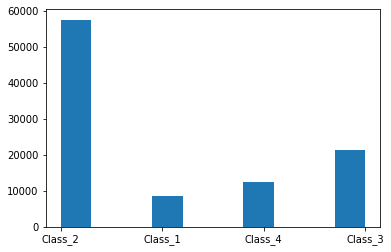

In [3]:
plt.hist(extras['target'])
plt.show()

<AxesSubplot:>

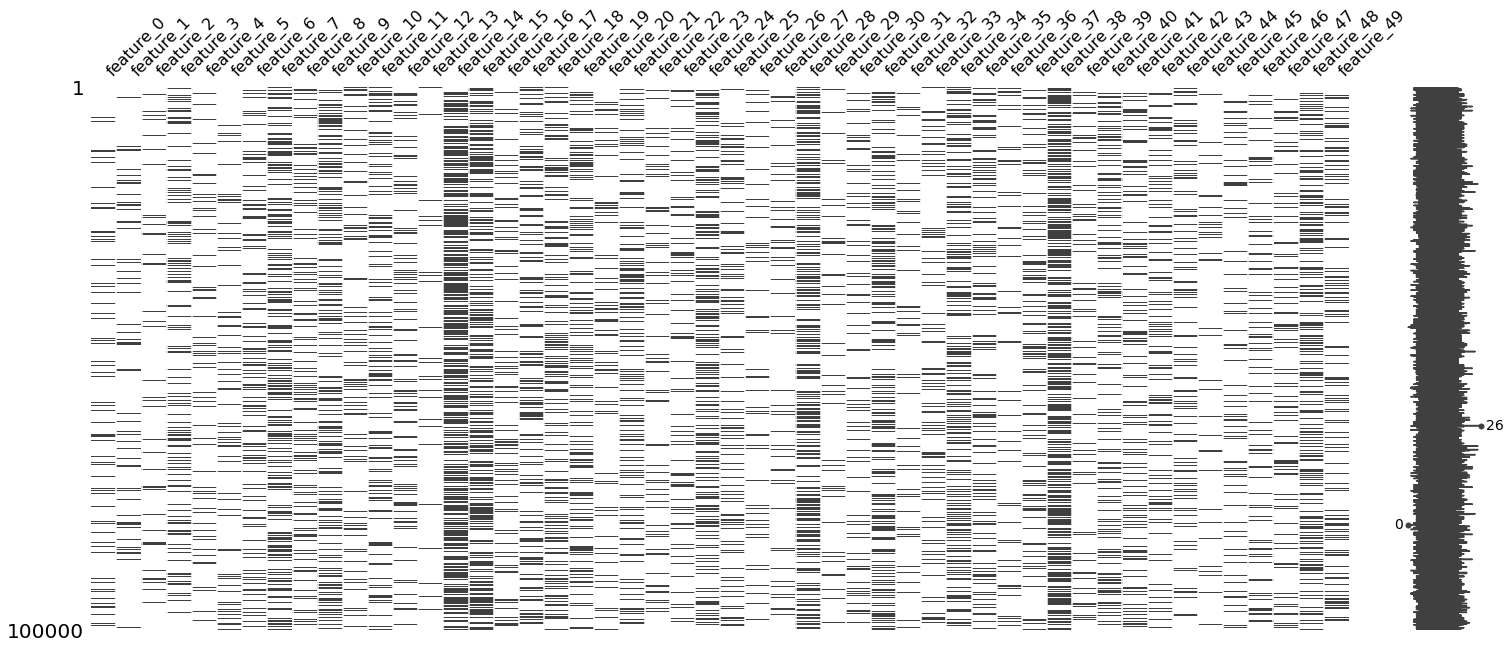

In [5]:
foo = raw_data.replace(0, np.nan)
msno.matrix(foo.drop(['id', 'target'], axis=1))

In [4]:
data.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


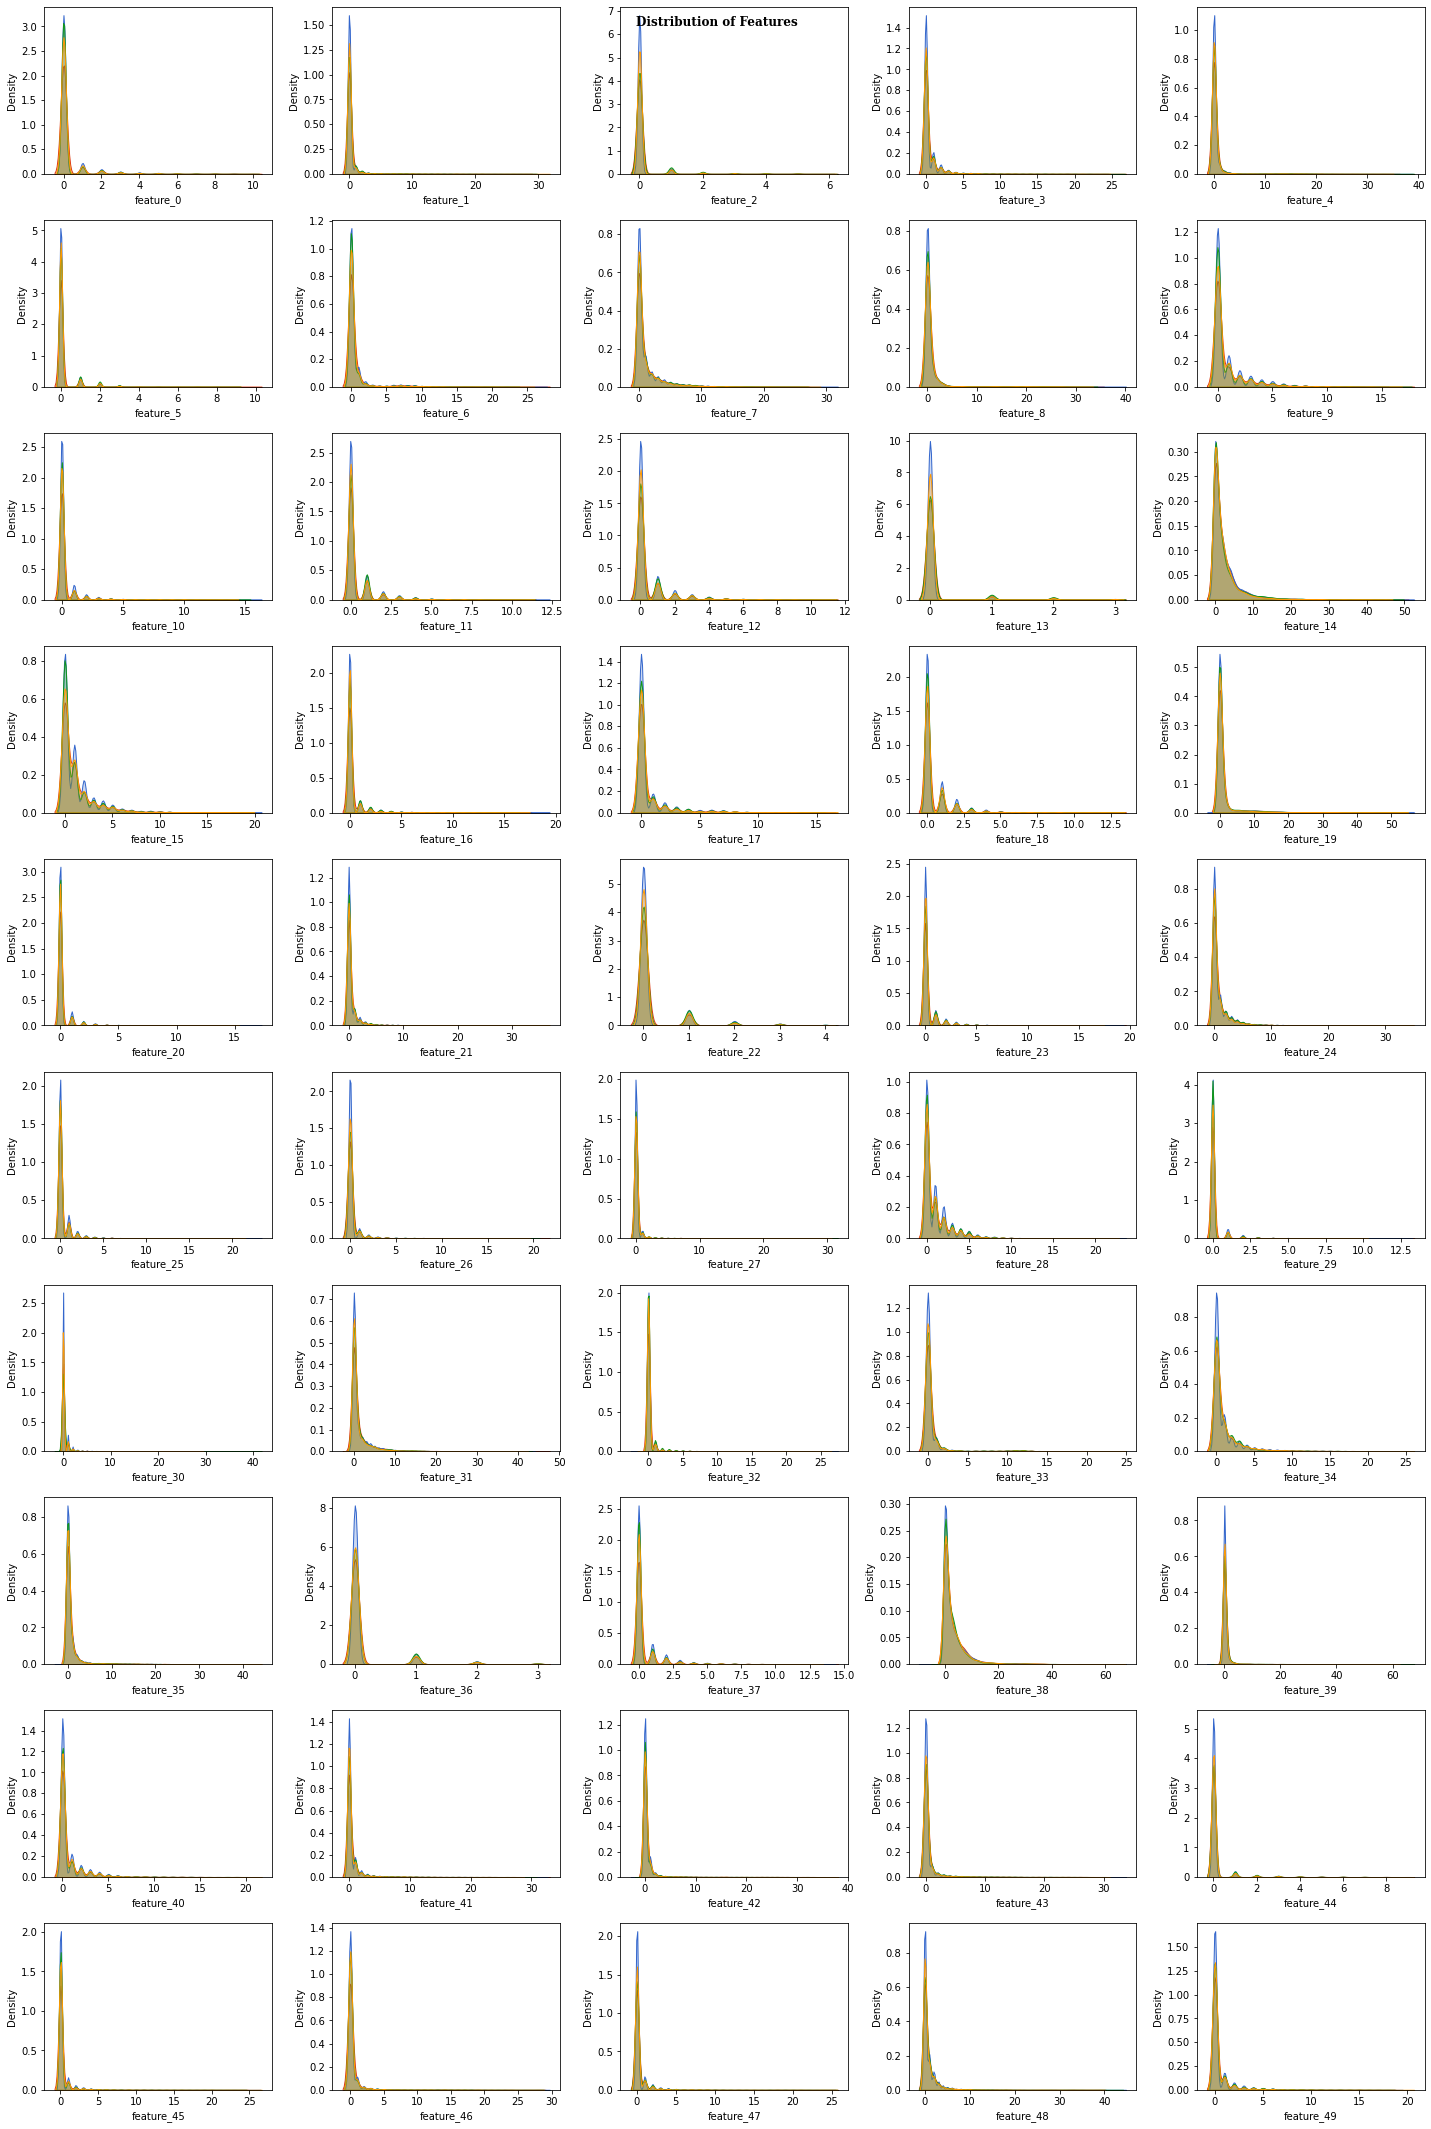

In [5]:
num_rows, num_cols = 10,5
feature_columns = data.columns.values
target_column = 'target'

f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 30))
f.suptitle('Distribution of Features', fontweight='bold', fontfamily='serif')

for index, column in enumerate(feature_columns):
    i,j = (index // num_cols, index % num_cols)

    sns.kdeplot(data.loc[extras[target_column] == 'Class_1', column], color=px.colors.qualitative.G10[1], shade=True, ax=axes[i,j])
    sns.kdeplot(data.loc[extras[target_column] == 'Class_2', column], color=px.colors.qualitative.G10[0], shade=True, ax=axes[i,j])
    sns.kdeplot(data.loc[extras[target_column] == 'Class_3', column], color=px.colors.qualitative.G10[3], shade=True, ax=axes[i,j])
    sns.kdeplot(data.loc[extras[target_column] == 'Class_4', column], color=px.colors.qualitative.G10[2], shade=True, ax=axes[i,j])

#f.delaxes(axes[3, 2])
plt.tight_layout()
plt.show()

In [6]:
pca_decomp = PCA()
pca_decomp.fit(data)
components = pca_decomp.transform(data)

# First Principal Component only explains 12% of the variance in the data.
# Not a good dimensioanlity reduction choice. 
pca_decomp.explained_variance_ratio_ 

array([0.11896023, 0.09249329, 0.08878577, 0.05713186, 0.04786787,
       0.04513803, 0.03576251, 0.03184584, 0.029728  , 0.02732761,
       0.02636074, 0.02547795, 0.02291704, 0.02244412, 0.02168922,
       0.02138421, 0.01963964, 0.01921659, 0.01906313, 0.01647167,
       0.01600202, 0.0148514 , 0.01446031, 0.01393512, 0.01354382,
       0.01212816, 0.01156108, 0.01037446, 0.00916854, 0.009018  ,
       0.00878374, 0.00871219, 0.00749125, 0.00716033, 0.00673763,
       0.00604818, 0.00521424, 0.00516608, 0.00495379, 0.00485337,
       0.00417801, 0.00353557, 0.0035128 , 0.00223601, 0.00161362,
       0.00147882, 0.00125411, 0.00110356, 0.00069207, 0.00052641])

In [7]:
features = [col for col in raw_data.columns if col != "id" and col != "target"]

scaler = StandardScaler().fit(raw_data[features])
raw_data[features] = scaler.transform(raw_data[features])

test[features] = scaler.transform(test[features])
test_ids = test['id']
test.drop('id', inplace=True, axis=1)

In [8]:
encoder = LabelEncoder()
target = pd.Series(encoder.fit_transform(raw_data['target']))
train = raw_data.drop(['id','target'], axis=1)

In [12]:
def CreateModel(feature_nums):
    hidden_units = [128, 64, 32]
    dropout_rates = [0.2, 0.2, 0.2]

    model_heads = [None]*len(feature_nums)
    for idx, i in enumerate(feature_nums):
        inp = tf.keras.Input(shape=(i,))
        for j in range(len(hidden_units)):
            if j == 0:
                x = tf.keras.layers.Dense(hidden_units[j])(inp)
            else:
                x = tf.keras.layers.Dense(hidden_units[j])(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
                x = tf.keras.layers.Dropout(dropout_rates[j])(x)

        model_heads[idx] = tf.keras.models.Model(inputs=inp, outputs=x)
    
    combined = Concatenate()([i.output for i in model_heads])

    z = tf.keras.layers.Dense(128)(combined)
    z = tf.keras.layers.Activation(tf.keras.activations.swish)(z)
    z = tf.keras.layers.Dense(64)(z)
    z = tf.keras.layers.Activation(tf.keras.activations.swish)(z)
    z = tf.keras.layers.Dense(4)(z)
    final = tf.keras.layers.Activation("softmax")(z)

    model = tf.keras.models.Model(inputs=[i.input for i in model_heads], outputs=final)
    model.compile(loss='mean_squared_logarithmic_error', optimizer="adam", metrics='accuracy')

    return model

In [13]:
N_FOLDS = 3
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof = np.zeros((train.shape[0],4))
pred = np.zeros((test.shape[0],4))

In [14]:
for fold, (tr_idx, ts_idx) in enumerate(skf.split(train, target)):
    # Neural Net with 5 heads 
    print(f"===== FOLD {fold} =====")  

    X_train1 = train.iloc[tr_idx, :10] # X_train
    X_train2 = train.iloc[tr_idx, 10:20] # X_train
    X_train3 = train.iloc[tr_idx, 20:30] # X_train
    X_train4 = train.iloc[tr_idx, 30:40] # X_train
    X_train5 = train.iloc[tr_idx, 40:] # X_train

    y_train = target.iloc[tr_idx] # y_train

    X_val1 = train.iloc[ts_idx, :10] # X_valid 
    X_val2 = train.iloc[ts_idx, 10:20] # X_valid
    X_val3 = train.iloc[ts_idx, 20:30] # X_valid 
    X_val4 = train.iloc[ts_idx, 30:40] # X_valid 
    X_val5 = train.iloc[ts_idx, 40:] # X_valid 

    X_test1 = test.iloc[:, :10] # X_train
    X_test2 = test.iloc[:, 10:20] # X_train
    X_test3 = test.iloc[:, 20:30] # X_train
    X_test4 = test.iloc[:, 30:40] # X_train
    X_test5 = test.iloc[:, 40:] # X_train

    y_val = target.iloc[ts_idx] # y_valid

    X_train1 = X_train1.values
    X_train2 = X_train2.values
    X_train3 = X_train3.values
    X_train4 = X_train4.values
    X_train5 = X_train5.values

    X_val1 = X_val1.values
    X_val2 = X_val2.values
    X_val3 = X_val3.values
    X_val4 = X_val4.values
    X_val5 = X_val5.values

    X_test1 = X_test1.values
    X_test2 = X_test2.values
    X_test3 = X_test3.values
    X_test4 = X_test4.values
    X_test5 = X_test5.values

    y_train = y_train.values
    y_val = y_val.values

    y_train =  to_categorical(y_train)
    y_val =  to_categorical(y_val)

    model = CreateModel([10, 10, 10, 10, 10])
    model.fit([X_train1, X_train2, X_train3, X_train4, X_train5], y_train,
          batch_size = 1000, epochs = 20, verbose = 2,
          validation_data=([X_val1, X_val2, X_val3, X_val4, X_val5], y_val))

    oof[ts_idx] = model.predict([X_val1, X_val2, X_val3, X_val4, X_val5])
    pred += model.predict([X_test1, X_test2, X_test3, X_test4, X_test5]) / N_FOLDS
    
    score = log_loss(y_val, oof[ts_idx])
    print(f"FOLD {fold} Score {score}\n")

score = log_loss(target, oof)
print(f"Score total {score}\n")

===== FOLD 0 =====
Epoch 1/20
67/67 - 4s - loss: 0.0758 - accuracy: 0.5627 - val_loss: 0.0776 - val_accuracy: 0.5750
Epoch 2/20
67/67 - 1s - loss: 0.0731 - accuracy: 0.5762 - val_loss: 0.0740 - val_accuracy: 0.5757
Epoch 3/20
67/67 - 1s - loss: 0.0728 - accuracy: 0.5759 - val_loss: 0.0728 - val_accuracy: 0.5762
Epoch 4/20
67/67 - 1s - loss: 0.0726 - accuracy: 0.5766 - val_loss: 0.0726 - val_accuracy: 0.5759
Epoch 5/20
67/67 - 1s - loss: 0.0725 - accuracy: 0.5768 - val_loss: 0.0726 - val_accuracy: 0.5772
Epoch 6/20
67/67 - 1s - loss: 0.0724 - accuracy: 0.5772 - val_loss: 0.0726 - val_accuracy: 0.5757
Epoch 7/20
67/67 - 1s - loss: 0.0724 - accuracy: 0.5772 - val_loss: 0.0725 - val_accuracy: 0.5760
Epoch 8/20
67/67 - 1s - loss: 0.0722 - accuracy: 0.5774 - val_loss: 0.0725 - val_accuracy: 0.5770
Epoch 9/20
67/67 - 1s - loss: 0.0722 - accuracy: 0.5777 - val_loss: 0.0726 - val_accuracy: 0.5755
Epoch 10/20
67/67 - 1s - loss: 0.0721 - accuracy: 0.5781 - val_loss: 0.0725 - val_accuracy: 0.5770


In [15]:
output = pd.DataFrame(pred, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4'])
output['id'] = test_ids.values
output[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']].to_csv('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Playground_Series_052021/sample_submission.csv', index=False)

# AutoEncoder

In [ ]:
# def get_autoencoder(dims):
#     n_stacks = len(dims)-1
#     x = tf.keras.Input(shape=(dims[0],), name='input')

#     h = x
#     for i in range(n_stacks-1):
#         h = tf.keras.layers.Dense(dims[i+1], name='encoder_%d' %i)(h)
#         h = tf.keras.layers.Activation(tf.keras.activations.swish)(h)

#     h = tf.keras.layers.Dense(dims[-1], name='encoder_%d' % (n_stacks-1))(h)

#     for i in range(n_stacks-1, 0, -1):
#         h = tf.keras.layers.Dense(dims[i], name='decoder_%d' % i)(h)
#         h = tf.keras.layers.Activation(tf.keras.activations.swish)(h)

#     h = tf.keras.layers.Dense(dims[0], name='decoder_0')(h)
#     model = tf.keras.models.Model(inputs=x, outputs=h)
#     model.summary()

#     return model

# Train, Valid = train_test_split(raw_data, test_size = .25, random_state=1234)

# Train_matrix = np.array(Train.drop(['id', 'target'], axis=1))
# Valid_matrix = np.array(Valid.drop(['id', 'target'], axis=1))

# encoded_dimensions = 20
# shape = [Train_matrix.shape[-1], 500, 500, 2000, encoded_dimensions]
# autoencoder = get_autoencoder(shape) 

# encoder_layer = f'encoder_{(len(shape)-2)}'
# hidden_encoder_layer = autoencoder.get_layer(name=encoder_layer).output
# encoder = tf.keras.models.Model(inputs=autoencoder.input, outputs=hidden_encoder_layer)

# autoencoder.compile(loss='mse', optimizer='adam')

# autoencoder.fit(
#     Train_matrix,
#     Train_matrix,
#     batch_size=100,
#     epochs=10,
#     verbose=1,
#     validation_data=(Valid_matrix, Valid_matrix)
# )

# X_encoded = pd.DataFrame(encoder.predict(Train_matrix))